# Ensemble Methods Using SKLearn

Implemented by Pratham Shah (240905614)

### Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

/home/pratham/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Reading the CSV file

In [3]:
original = pd.read_csv("Threats (1).csv")
data = original.copy()
unique_ids = {}
data.head()

,Unnamed: 0,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,40000,40001,0.012996,tcp,-,FIN,16,18,1540,1644,...,1,6,0,0,0,5,7,0,Normal,0
1,40001,40002,0.004119,tcp,-,FIN,12,12,1064,2260,...,1,1,0,0,0,3,8,0,Normal,0
2,40002,40003,0.000988,udp,dns,CON,2,2,146,178,...,1,2,0,0,0,7,2,0,Normal,0
3,40003,40004,3.415787,tcp,ssh,FIN,230,238,24344,29556,...,1,1,0,0,0,4,1,0,Normal,0
4,40004,40005,0.193943,tcp,-,FIN,72,74,4238,63618,...,1,5,0,0,0,6,12,0,Normal,0


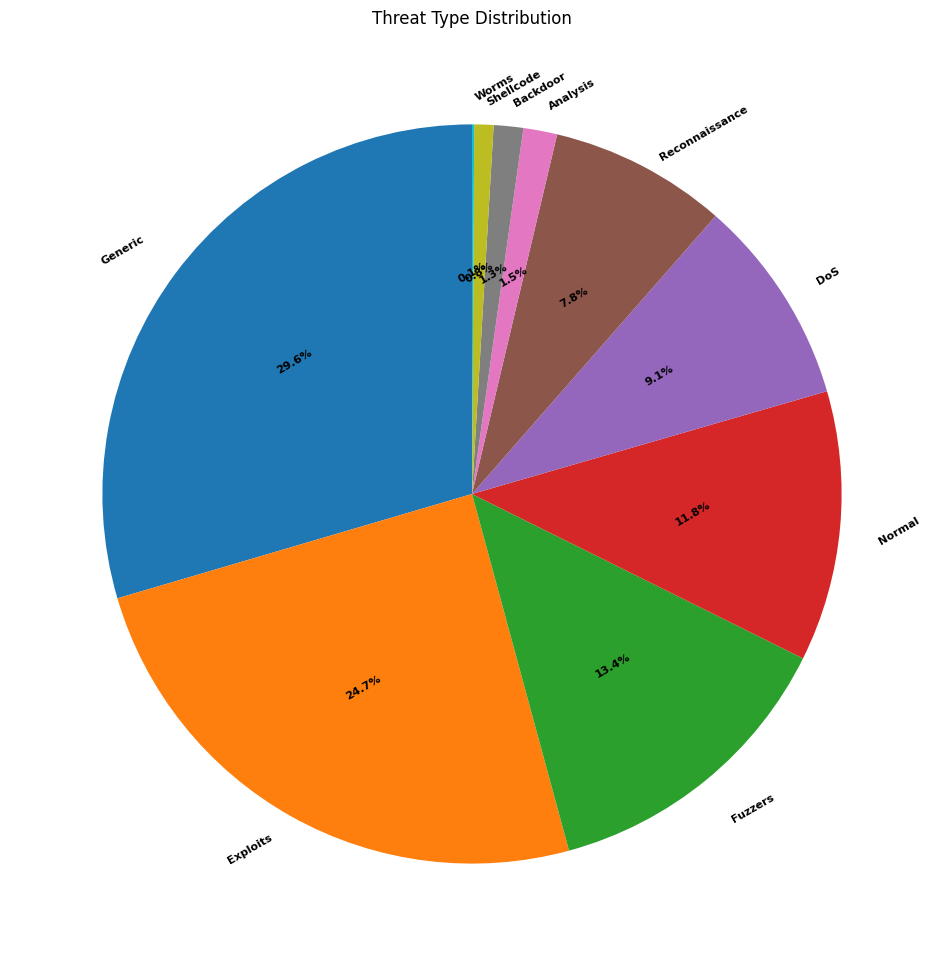

In [4]:
distributions = data['attack_cat'].value_counts()

plt.figure(figsize=(12, 12))
plt.pie(distributions, labels=distributions.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8, 'weight': 'bold', 'rotation': 30})

plt.title('Threat Type Distribution')

plt.show()

### Encoding Textual Data

SKLearn doesn't accept textual data, so I've encoded it into unique numerical values.

In [5]:
def unique_item_code (item):
    if item != "":
        sum_of_ords = sum([ord(val) for val in item])
        length = len(item)
        ord_first = ord(item[0])
        ord_last = ord(item[-1])
        unique_id = sum_of_ords+length+ord_first*2+ord_last
    else: unique_id = 1

    if unique_id not in unique_ids.keys():
        unique_ids[unique_id] = item

    return unique_id

def frequency_encoding(columns):
    global data
    for col in columns:
        data[col + '_freq'] = [unique_item_code(item) for item in data[col].values]
        data.drop(col, axis=1, inplace=True)
frequency_encoding(["proto", "service", "state", "attack_cat"])
titles = list(data)[1:-1]

titles = list(data)[1:-1]
accuracy_list = []
X= data[titles].values
y= data['attack_cat_freq'].values
data.head()



,Unnamed: 0,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,...,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto_freq,service_freq,state_freq,attack_cat_freq
0,40000,40001,0.012996,16,18,1540,1644,2539.242797,31,29,...,0,0,5,7,0,0,674,181,442,887
1,40001,40002,0.004119,12,12,1064,2260,5583.879675,31,29,...,0,0,3,8,0,0,674,181,442,887
2,40002,40003,0.000988,2,2,146,178,3036.437382,31,29,...,0,0,7,2,0,0,678,643,439,887
3,40003,40004,3.415787,230,238,24344,29556,136.718127,31,29,...,0,0,4,1,0,0,674,671,442,887
4,40004,40005,0.193943,72,74,4238,63618,747.642372,31,29,...,0,0,6,12,0,0,674,181,442,887


### K-Fold cross evaluation

Allows a better understanding of how the model reacts to new data.

In [6]:
classes =  list(map(lambda x: unique_ids[x],data['attack_cat_freq']))

def crossval(X, y, clf):
    kf = KFold(n_splits=10, shuffle=False)
    accuracy_list = []
    n= 0
    print("Cross validation for each fold:")
    for train_index, test_index in kf.split(X, y):
        clf.fit(X[train_index], y[train_index])
        score = clf.score(X[test_index], y[test_index])
        accuracy_list.append(score)
        print("\nModel iteration {0}:".format(n+1))
        train_predictions = clf.predict(X[train_index])
        train_accuracy = accuracy_score(y[train_index], train_predictions)
        total_predictions = clf.predict(X)
        total_accuracy = accuracy_score(y, total_predictions)
        print("Accuracies on:\nTraining Data: {0}\nTesting Data (Score): {1}\nTotal Data: {2}".format(train_accuracy, score, total_accuracy))
        n += 1
    print("*" * 20)
    print("Total Model:\nPrecision Score:", precision_score(y, clf.predict(X), average="weighted", zero_division=1), "\nRecall Score:", recall_score(y, clf.predict(X), average="weighted", zero_division=1), "\nF1 Score:", f1_score(y, clf.predict(X), average="weighted", zero_division=1), "\nMCC:", matthews_corrcoef(y, clf.predict(X)))
    classes =  list(map(lambda x: f"{x} : {unique_ids[x]}",set(data['attack_cat_freq'])))
    print(classes)
    print(classification_report(y, clf.predict(X)))

### Decision Tree Classifier

With Matthews Score, Score and Graph.

Cross validation for each fold:

Model iteration 1:
Accuracies on:
Training Data: 0.8099436809352577
Testing Data (Score): 0.8995197635759143
Total Data: 0.8189018848685912

Model iteration 2:
Accuracies on:
Training Data: 0.8256996724326188
Testing Data (Score): 0.7277966602630412
Total Data: 0.8159094435536903

Model iteration 3:
Accuracies on:
Training Data: 0.8257981889382383
Testing Data (Score): 0.725580020688636
Total Data: 0.8157764461619169

Model iteration 4:
Accuracies on:
Training Data: 0.8282118433259172
Testing Data (Score): 0.7020836411999409
Total Data: 0.8155991163062191

Model iteration 5:
Accuracies on:
Training Data: 0.8221448685215136
Testing Data (Score): 0.7470814245603665
Total Data: 0.8146385795878559

Model iteration 6:
Accuracies on:
Training Data: 0.8220053034718858
Testing Data (Score): 0.7526230234963794
Total Data: 0.8150671267391256

Model iteration 7:
Accuracies on:
Training Data: 0.8100930160007225
Testing Data (Score): 0.8554750997487809
Total Data: 0

/home/pratham/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pratham/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pratham/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         484       0.40      0.18      0.24     12264
         830       0.00      0.00      0.00       130
         887       1.00      1.00      1.00     16000
         949       1.00      0.98      0.99     40000
        1023       0.83      0.88      0.86     18184
        1059       0.45      0.12      0.19      1746
        1089       0.66      0.21      0.32      2000
        1117       0.64      0.86      0.74     33393
        1191       0.55      0.51      0.53      1133
        1731       0.85      0.71      0.77     10491

    accuracy                           0.82    135341
   macro avg       0.64      0.54      0.56    135341
weighted avg       0.81      0.82      0.80    135341



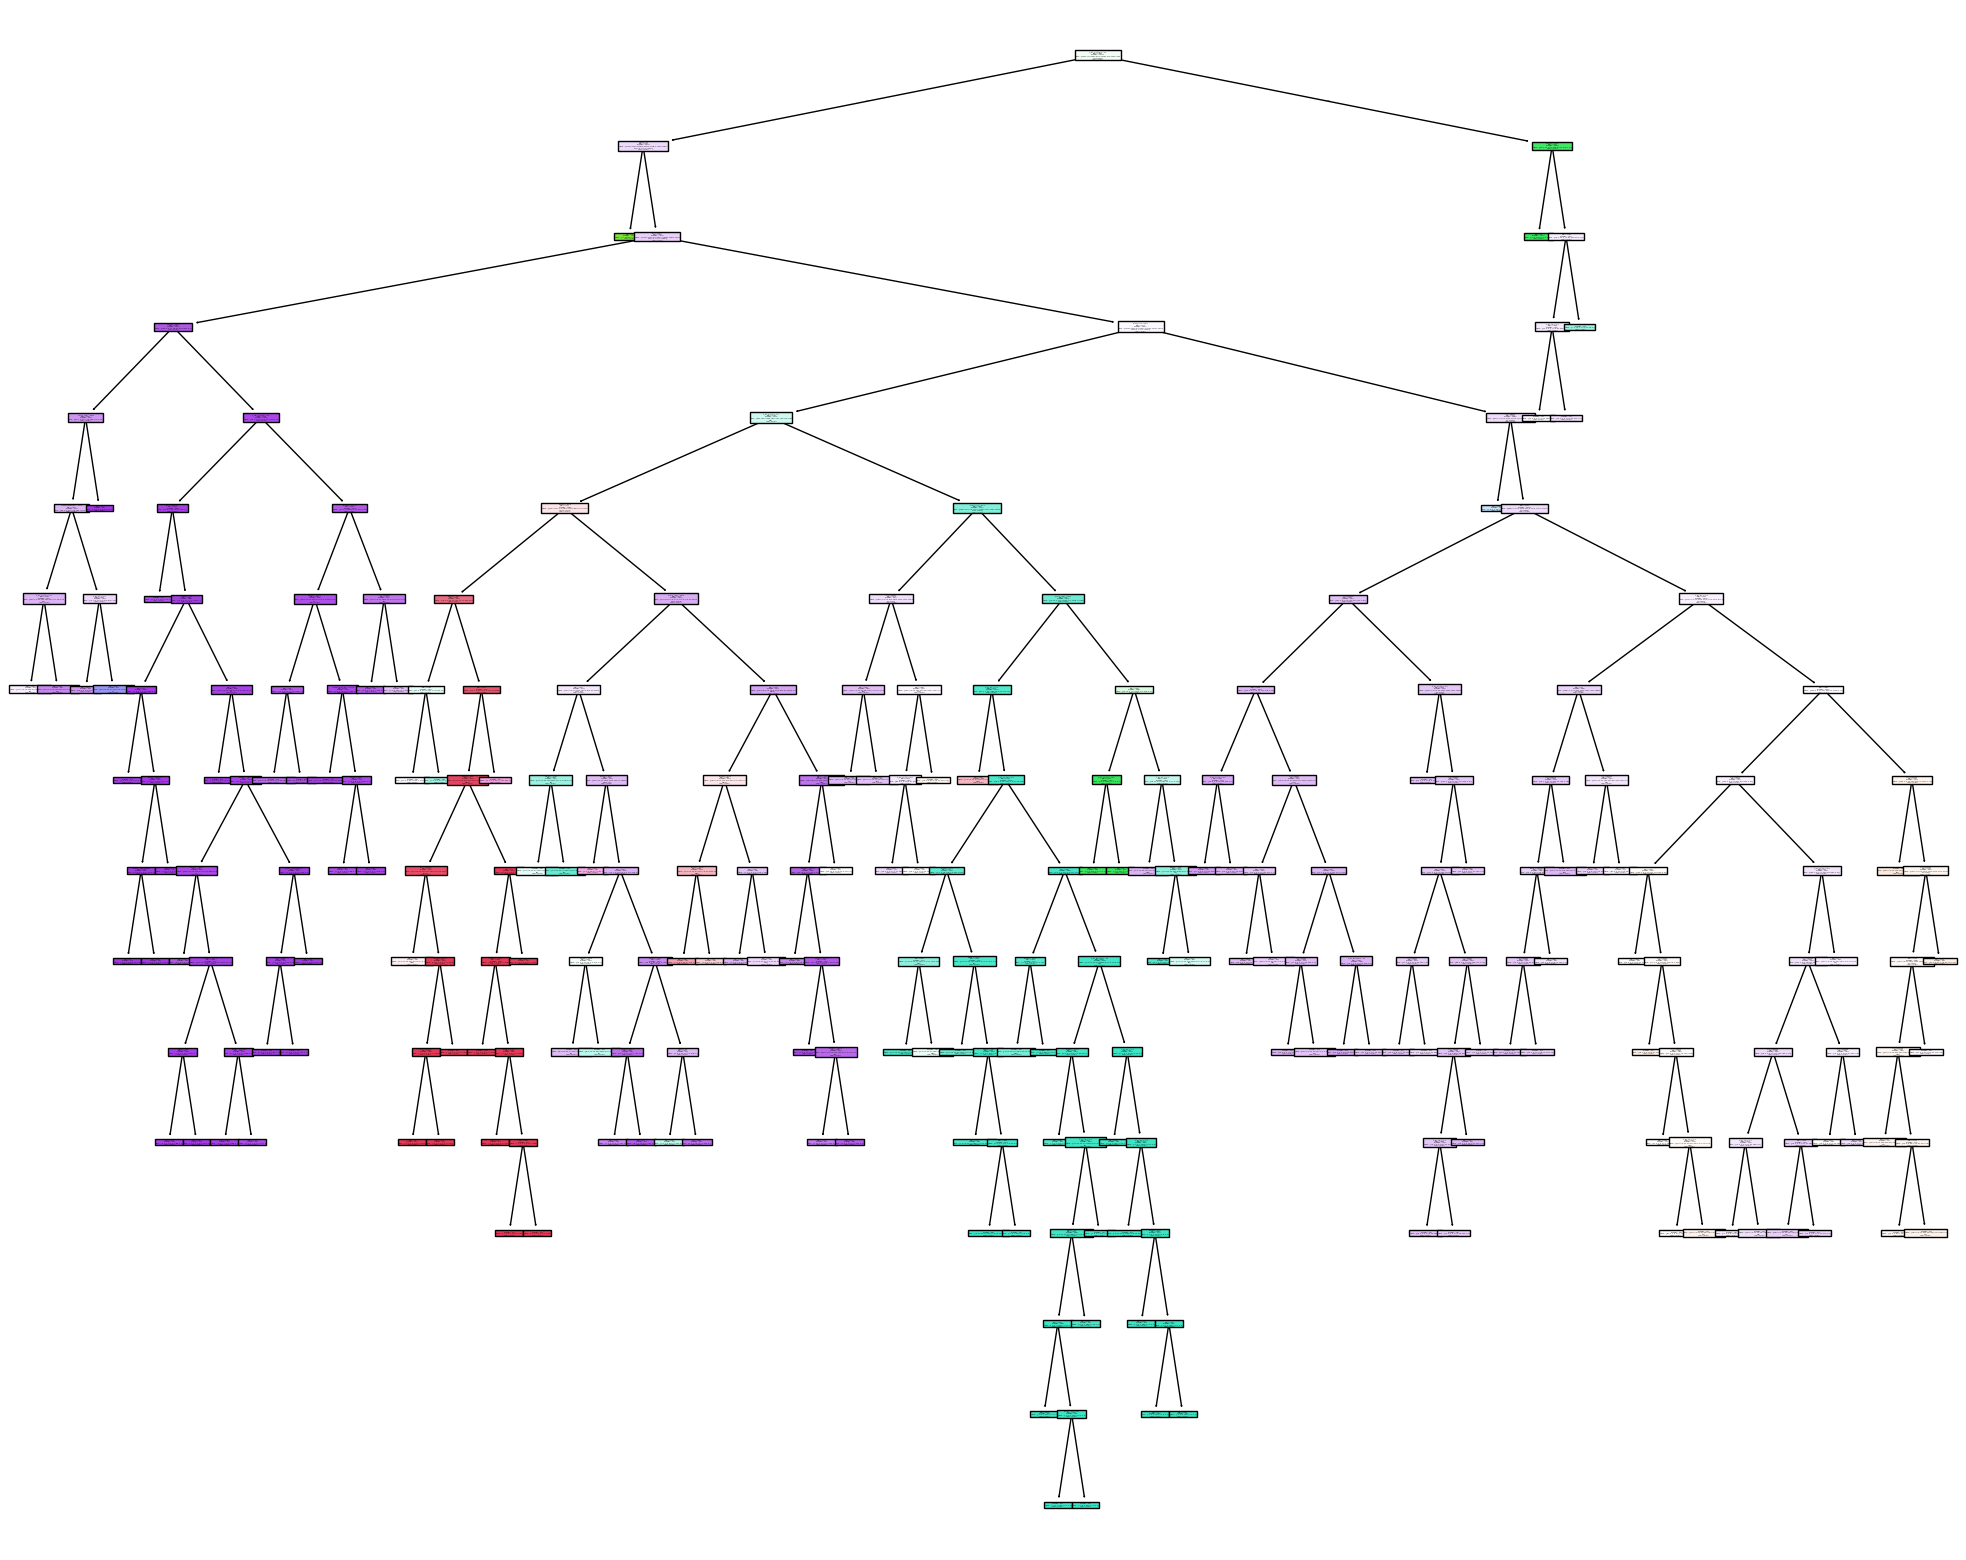

In [7]:
clf = DecisionTreeClassifier(min_samples_leaf=int(len(data)/300))

crossval(data[titles].values, data['attack_cat_freq'].values, clf)
clf.fit(X, y)
clfscore = clf.score(X, y)

y_pred = clf.predict(X)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, feature_names=titles, class_names=classes, filled=True)

### Bagging Classifier

Along with score and K-Fold cross-validation.

In [8]:
class BaggingClassifier:
    
    def __init__(self, base_classifier, num_models, is_random_forest):
        self.base_classifier = base_classifier
        self.num_models = num_models
        self.classifiers = []
        self.is_random_forest = is_random_forest
        
    def fit(self, X, y):
          for _ in range(self.num_models):
              # Bootstrap sampling with replacement
              indices = np.random.choice(len(X), len(X), replace=True)
              X_sampled = X[indices]
              y_sampled = y[indices]

              # Create a new base classifier and train it on the sampled data
              classifier = self.base_classifier
              classifier.fit(X_sampled, y_sampled)

              # Store the trained classifier in the list of classifiers
              self.classifiers.append(classifier)
          return self.classifiers

    def predict(self, X):
        # Make predictions using all the base classifiers
        predictions = [classifier.predict(X) for classifier in self.classifiers]
        # Aggregate predictions using majority voting
        majority_votes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        return majority_votes

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))


In [9]:
bag = BaggingClassifier(clf, 3, is_random_forest=False)
bag.fit(X, y)
bagscore = bag.score(X, y)

crossval(data[titles].values, data['attack_cat_freq'].values, bag)

Cross validation for each fold:

Model iteration 1:
Accuracies on:
Training Data: 0.8058880514917164
Testing Data (Score): 0.8958256372367935
Total Data: 0.8148824081394404

Model iteration 2:
Accuracies on:
Training Data: 0.8252645578661325
Testing Data (Score): 0.7280183242204817
Total Data: 0.8155400063543198

Model iteration 3:
Accuracies on:
Training Data: 0.8263728685543523
Testing Data (Score): 0.7229200531993498
Total Data: 0.8160276634574889

Model iteration 4:
Accuracies on:
Training Data: 0.8270624840936892
Testing Data (Score): 0.6997192256539086
Total Data: 0.8143282523403846

Model iteration 5:
Accuracies on:
Training Data: 0.8212007520093262
Testing Data (Score): 0.7487069602482637
Total Data: 0.8139514263970268

Model iteration 6:
Accuracies on:
Training Data: 0.8218985772574646
Testing Data (Score): 0.758681838333087
Total Data: 0.8155769500742569

Model iteration 7:
Accuracies on:
Training Data: 0.812202911162741
Testing Data (Score): 0.8597606029259642
Total Data: 0.

/home/pratham/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pratham/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pratham/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Random Forest Classifier

Along with K-Fold cross-validation and score.

In [10]:
rdfo = BaggingClassifier(clf, 3, is_random_forest=True)
rdfo.fit(X,y)
rdfoscore = rdfo.score(X, y)

crossval(data[titles].values, data['attack_cat_freq'].values, rdfo)

Cross validation for each fold:

Model iteration 1:
Accuracies on:
Training Data: 0.8056499679818728
Testing Data (Score): 0.8969338751385297
Total Data: 0.8147789657236166

Model iteration 2:
Accuracies on:
Training Data: 0.8243861190243582
Testing Data (Score): 0.7272794443623467
Total Data: 0.8146755233077929

Model iteration 3:
Accuracies on:
Training Data: 0.8249115403876625
Testing Data (Score): 0.7168612383626423
Total Data: 0.8141065900207624

Model iteration 4:
Accuracies on:
Training Data: 0.8307979015984303
Testing Data (Score): 0.7063691443771243
Total Data: 0.8183551178135229

Model iteration 5:
Accuracies on:
Training Data: 0.8240495209634914
Testing Data (Score): 0.7501847199645337
Total Data: 0.816663095440406

Model iteration 6:
Accuracies on:
Training Data: 0.8211679131741197
Testing Data (Score): 0.7543224471700901
Total Data: 0.8144834159641202

Model iteration 7:
Accuracies on:
Training Data: 0.8087384140484537
Testing Data (Score): 0.851854588443919
Total Data: 0.

/home/pratham/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pratham/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pratham/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Boosting

Along with score.

In [ ]:
boo = AdaBoostClassifier(clf)
boo.fit(X, y)
booscore = boo.score(X, y)
print("Boosted score : ", booscore)

/home/pratham/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### Comparing the scores

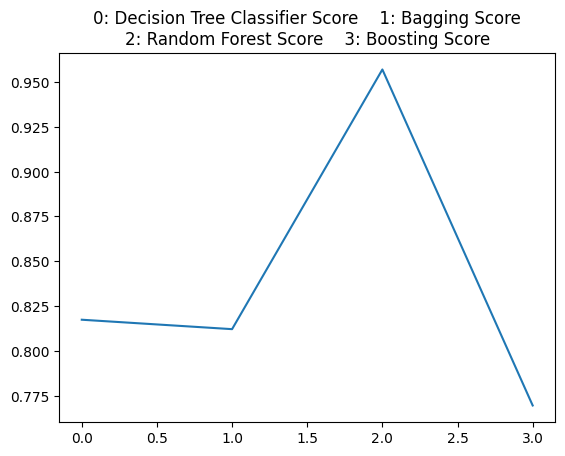

In [ ]:
scores = [clfscore, bagscore, rdfoscore, booscore]
plt.plot([index for index, item in enumerate(scores)], scores)
plt.title("0: Decision Tree Classifier Score    1: Bagging Score\n2: Random Forest Score    3: Boosting Score")
plt.show()